In [67]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
from fbprophet import Prophet
import pandas as pd 
from fbprophet.plot import plot_plotly, plot_forecast_component_plotly,plot_cross_validation_metric
import numpy as np
from fbprophet.diagnostics import cross_validation,performance_metrics
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
af = pd.read_csv('africa_data.csv')

In [3]:
af.describe()

,Confirmed,Deaths,Recovered,Latitude,Longitude,Active
count,2204.000000,2204.000000,2204.000000,2180.000000,2180.000000,2204.000000
mean,228.401089,11.087568,49.097550,4.359782,16.386379,168.215971
std,584.578171,43.004904,163.862702,15.722826,19.763681,414.688607
min,0.000000,0.000000,0.000000,-30.559500,-23.041800,0.000000
25%,6.000000,0.000000,0.000000,-4.322447,0.824800,5.000000
50%,26.000000,1.000000,2.000000,6.877000,17.228331,21.000000
75%,139.250000,4.000000,18.000000,14.497400,31.307000,109.250000
max,4793.000000,432.000000,1558.000000,34.000000,57.552200,3311.000000


In [4]:
af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2204 entries, 0 to 2203
Data columns (total 8 columns):
date              2204 non-null object
Country/Region    2204 non-null object
Confirmed         2204 non-null int64
Deaths            2204 non-null int64
Recovered         2204 non-null int64
Latitude          2180 non-null float64
Longitude         2180 non-null float64
Active            2204 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 137.8+ KB


In [5]:
af[af.isnull().any(axis=1)]

,date,Country/Region,Confirmed,Deaths,Recovered,Latitude,Longitude,Active
0,2020-01-27,Ivory Coast,1,0,0,NaN,NaN,1
1,2020-02-14,Egypt,1,0,0,NaN,NaN,1
2,2020-02-15,Egypt,1,0,0,NaN,NaN,1
3,2020-02-16,Egypt,1,0,0,NaN,NaN,1
4,2020-02-17,Egypt,1,0,0,NaN,NaN,1
5,2020-02-18,Egypt,1,0,0,NaN,NaN,1
6,2020-02-19,Egypt,1,0,0,NaN,NaN,1
7,2020-02-20,Egypt,1,0,0,NaN,NaN,1
8,2020-02-21,Egypt,1,0,0,NaN,NaN,1
9,2020-02-22,Egypt,1,0,0,NaN,NaN,1


In [6]:
af['date'] = pd.to_datetime(af.date)

In [7]:
af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2204 entries, 0 to 2203
Data columns (total 8 columns):
date              2204 non-null datetime64[ns]
Country/Region    2204 non-null object
Confirmed         2204 non-null int64
Deaths            2204 non-null int64
Recovered         2204 non-null int64
Latitude          2180 non-null float64
Longitude         2180 non-null float64
Active            2204 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 137.8+ KB


In [8]:
fig = px.bar(af, x='date',y='Confirmed',hover_data=['Country/Region', 'Deaths', 'Recovered'], color='Country/Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for each country',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [11]:
fig = px.line(af, x="date", y="Confirmed", color='Country/Region', hover_data=['Country/Region','Deaths'])
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed Plot for each Country',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [12]:

fig = px.line(pd.DataFrame(af.groupby('date')['Confirmed'].sum().reset_index()), x="date", y="Confirmed")
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Showing Deaths of total country',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [13]:
#Forecasting confirmed cases
confirmed_dataset = pd.DataFrame(af.groupby('date')['Confirmed'].sum().reset_index()).rename(columns={'date': 'ds', 'Confirmed': 'y'})

In [15]:
confirmed_dataset.tail()

,ds,y
70,2020-04-23,26357
71,2020-04-24,27991
72,2020-04-25,29222
73,2020-04-26,30683
74,2020-04-27,32003


In [16]:
#Make the model
prophet = Prophet()
confirmed_prophet = prophet.fit(confirmed_dataset)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = prophet.make_future_dataframe(periods=90)
confirmed_forecast = prophet.predict(future)

In [33]:

fig = plot_plotly(prophet, confirmed_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [19]:
death_dataset = pd.DataFrame(af.groupby('date')['Deaths'].sum().reset_index()).rename(columns={'date': 'ds', 'Deaths': 'y'})
death_dataset.tail()

,ds,y
70,2020-04-23,1283
71,2020-04-24,1310
72,2020-04-25,1361
73,2020-04-26,1409
74,2020-04-27,1448


In [34]:
death_prophet = Prophet()
death_fit = death_prophet.fit(death_dataset,growth='exponential')
death_future = death_prophet.make_future_dataframe(periods=90)
deaths_forecast = death_prophet.predict()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
fig = plot_plotly(death_prophet, deaths_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions of Deaths',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [29]:
dates=['April 2', 'April 4']

fig = go.Figure(data=[
    go.Bar(name='Predicted', x=dates, y=[6928, 8306]),
    go.Bar(name='Actual', x=dates, y=[6838, 8347])
])
# Change the bar mode
fig.update_layout(barmode='group', title_text='Predictions and Actual Data from Apr 2 and 4')
fig.show()

In [59]:
# Measuring model performance
af_cv = cross_validation(prophet,horizon='15 days',initial='30 days')
af_cv.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-27 00:00:00 and 2020-04-12 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-28,1.191813,0.830550,1.568325,3,2020-02-27
1,2020-02-29,1.191765,0.807543,1.548082,3,2020-02-27
2,2020-03-01,1.191717,0.807641,1.529567,4,2020-02-27
3,2020-03-02,1.342130,0.962731,1.719351,8,2020-02-27
4,2020-03-03,1.692239,1.275769,2.056135,11,2020-02-27


In [60]:
df_p = performance_metrics(af_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days 12:00:00,6.305839e+06,2511.142944,1549.182946,0.618194,0.679648,0.0
1,2 days 00:00:00,4.439433e+06,2106.996264,1249.986812,0.557880,0.637946,0.0
2,2 days 12:00:00,7.572671e+06,2751.848591,1745.207031,0.633807,0.678759,0.0
3,3 days 00:00:00,6.107277e+06,2471.290598,1509.685538,0.591121,0.694691,0.0
4,3 days 12:00:00,1.006657e+07,3172.786542,2075.836613,0.671266,0.723711,0.0


In [64]:
fig = plot_cross_validation_metric(af_cv, metric= 'mape')rage')

SyntaxError: invalid syntax (<ipython-input-64-f6160e5beb43>, line 1)

In [62]:
plot_forecast_component_plotly(prophet, confirmed_forecast,'trend')

In [65]:
def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [66]:
mape_baseline = mape(af_cv.y,af_cv.yhat)
print(mape_baseline)

72.3690960337705


## Epidermology Models

In [68]:
# Total population, N.
N = 41265585
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

In [69]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [70]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

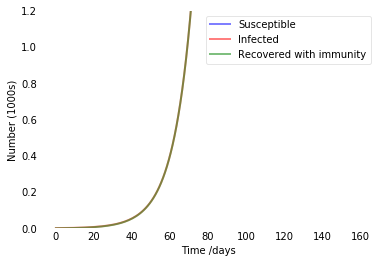

In [72]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()